In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols #more advanced than scikit-learn
from statsmodels.formula.api import ols as sm_ols

from statsmodels.tsa.stattools import adfuller #?
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score #haven't implemented the r2_score yet
from sklearn.linear_model import LinearRegression #haven't implemented yet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split #haven't implemented yet
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from math import sqrt
import seaborn as sns
import pandas_datareader.data as reader
import math
import matplotlib.pyplot as plt

import pandas_datareader as pdr 
from statsmodels.tsa.stattools import adfuller

import sys


In [2]:
returns = pd.read_csv('returns.csv')
returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format
returns['RET'] = returns['RET'].apply(pd.to_numeric, errors='coerce') #had to change the ret to numeric values 
returns = returns.drop(['PRC','PERMNO'],axis=1)
returns = returns.rename(columns={'date':'Date'})
returns

,Date,NCUSIP,TICKER,RET,ewretd,sprtrn
0,2000-01-03,13810830,CITI,-0.067797,0.002878,-0.009549
1,2000-01-04,13810830,CITI,-0.072727,-0.017465,-0.038345
2,2000-01-05,13810830,CITI,0.078431,0.007821,0.001922
3,2000-01-06,13810830,CITI,-0.018182,0.004504,0.000956
4,2000-01-07,13810830,CITI,-0.055556,0.017008,0.027090
...,...,...,...,...,...,...
15928,2020-12-24,02079K30,GOOGL,0.003431,-0.000277,0.003537
15929,2020-12-28,02079K30,GOOGL,0.022951,0.001350,0.008723
15930,2020-12-29,02079K30,GOOGL,-0.009132,-0.008483,-0.002227
15931,2020-12-30,02079K30,GOOGL,-0.012237,0.010155,0.001342


In [3]:
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2000,end=2021)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess"}) 
ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] / 100 #convert to decimal format 
ff['year'] = ff['Date'].dt.year
ff['month'] = ff['Date'].dt.month

ff

,Date,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,2000-01-03,-0.0071,-0.0009,-0.0140,-0.0146,-0.0077,0.00021,2000,1
1,2000-01-04,-0.0406,0.0035,0.0206,0.0043,0.0146,0.00021,2000,1
2,2000-01-05,-0.0009,0.0031,0.0019,0.0042,0.0101,0.00021,2000,1
3,2000-01-06,-0.0073,-0.0003,0.0127,0.0065,0.0119,0.00021,2000,1
4,2000-01-07,0.0321,-0.0095,-0.0142,-0.0087,-0.0095,0.00021,2000,1
...,...,...,...,...,...,...,...,...,...
5279,2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000,2020,12
5280,2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000,2020,12
5281,2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000,2020,12
5282,2020-12-30,0.0027,0.0103,0.0004,-0.0067,-0.0006,0.00000,2020,12


In [4]:
Returns = pd.merge(returns, ff, on='Date',how='inner')
Returns

Returns = Returns[(Returns['TICKER'] == 'AAPL') | 
                  (Returns['TICKER'] == 'COKE') |
                  (Returns['TICKER'] == 'GOOGL')]

#get in logrithmic returns to account for continuous compounding (didn't apply it to risk free rate)
Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']] = np.log(1 + Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']])
Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']] = 1 + Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']]
Returns

,Date,NCUSIP,TICKER,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
1,2000-01-03,19109810,COKE,1.020888,1.002874,0.990405,0.992875,0.999100,0.985901,0.985292,0.992270,1.00021,2000,1
2,2000-01-03,03783310,AAPL,1.085034,1.002874,0.990405,0.992875,0.999100,0.985901,0.985292,0.992270,1.00021,2000,1
4,2000-01-04,19109810,COKE,1.019828,0.982381,0.960900,0.958553,1.003494,1.020391,1.004291,1.014494,1.00021,2000,1
5,2000-01-04,03783310,AAPL,0.911923,0.982381,0.960900,0.958553,1.003494,1.020391,1.004291,1.014494,1.00021,2000,1
7,2000-01-05,19109810,COKE,1.033015,1.007791,1.001920,0.999100,1.003095,1.001898,1.004191,1.010049,1.00021,2000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15928,2020-12-30,03783310,AAPL,0.991436,1.010104,1.001341,1.002696,1.010247,1.000400,0.993277,0.999400,1.00000,2020,12
15929,2020-12-30,02079K30,GOOGL,0.987688,1.010104,1.001341,1.002696,1.010247,1.000400,0.993277,0.999400,1.00000,2020,12
15930,2020-12-31,19109810,COKE,0.999137,0.998941,1.006418,1.003892,0.993076,1.004490,1.005584,0.997998,1.00000,2020,12
15931,2020-12-31,03783310,AAPL,0.992267,0.998941,1.006418,1.003892,0.993076,1.004490,1.005584,0.997998,1.00000,2020,12


In [5]:
Returns_monthly = (Returns.groupby('TICKER').resample('M', on='Date').prod() -1).reset_index()
Returns_monthly['year'], Returns_monthly['month'] = Returns_monthly['Date'].dt.year, Returns_monthly['Date'].dt.month
Returns_monthly['RET'] = Returns_monthly['RET'] - Returns_monthly['RF']
Returns_monthly

,TICKER,Date,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,AAPL,2000-01-31,-0.026512,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,2000,1
1,AAPL,2000-02-29,0.088513,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,2000,2
2,AAPL,2000-03-31,0.146552,0.010345,0.093186,0.045368,-0.141438,0.074089,0.113542,-0.015726,0.004610,2000,3
3,AAPL,2000-04-30,-0.111473,-0.081621,-0.034751,-0.069142,-0.055609,0.074341,0.067247,0.053853,0.004569,2000,4
4,AAPL,2000-05-31,-0.339764,-0.050879,-0.024436,-0.046803,-0.044118,0.047078,0.039743,0.006877,0.005072,2000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,GOOGL,2020-08-31,0.093503,0.040180,0.069674,0.076088,-0.009448,-0.029964,0.040520,-0.013719,0.000000,2020,8
581,GOOGL,2020-09-30,-0.105532,-0.025043,-0.041636,-0.038699,0.000152,-0.030188,-0.012516,-0.018802,0.000000,2020,9
582,GOOGL,2020-10-31,0.096226,0.003063,-0.029482,-0.022722,0.046907,0.039253,-0.005573,-0.005520,0.000000,2020,10
583,GOOGL,2020-11-30,0.082548,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,2020,11


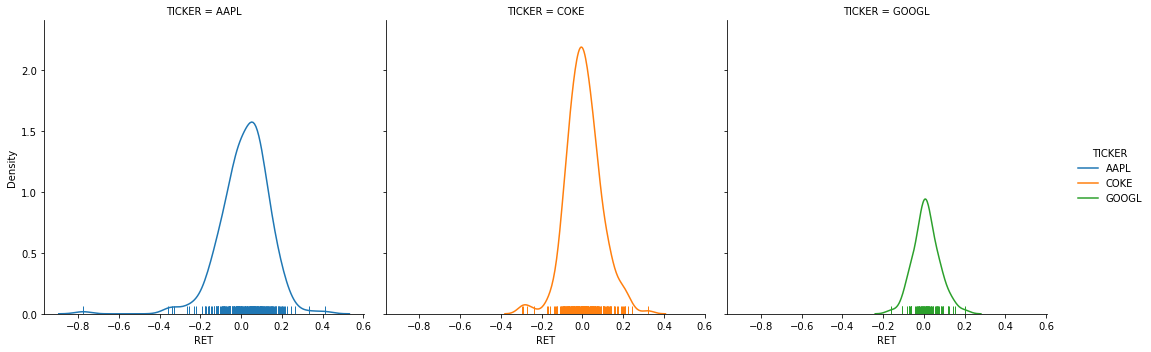

In [6]:
sns.displot(data=Returns_monthly, col='TICKER', x='RET', hue='TICKER', kind='kde', palette='tab10', rug=True)

#sns.boxplot(data=Returns_monthly,x='TICKER',y='RET')

plt.show()


In [7]:
mean = Returns_monthly.groupby(['TICKER'])['RET'].mean().round(4)
var = Returns_monthly.groupby(['TICKER'])['RET'].std().round(4)
print(mean,var)

TICKER
AAPL     0.0194
COKE     0.0061
GOOGL    0.0124
Name: RET, dtype: float64 TICKER
AAPL     0.1211
COKE     0.0864
GOOGL    0.0627
Name: RET, dtype: float64


In [8]:
data_filt = Returns_monthly.copy()
data_filt = data_filt.drop(columns=['sprtrn','RF','year','month'],axis=1)
data_filt

,TICKER,Date,RET,ewretd,mkt_excess,SMB,HML,RMW,CMA
0,AAPL,2000-01-31,-0.026512,0.054863,-0.049817,0.042313,-0.022284,-0.062559,0.046051
1,AAPL,2000-02-29,0.088513,0.110299,0.023900,0.175060,-0.077177,-0.156429,-0.013442
2,AAPL,2000-03-31,0.146552,0.010345,0.045368,-0.141438,0.074089,0.113542,-0.015726
3,AAPL,2000-04-30,-0.111473,-0.081621,-0.069142,-0.055609,0.074341,0.067247,0.053853
4,AAPL,2000-05-31,-0.339764,-0.050879,-0.046803,-0.044118,0.047078,0.039743,0.006877
...,...,...,...,...,...,...,...,...,...
580,GOOGL,2020-08-31,0.093503,0.040180,0.076088,-0.009448,-0.029964,0.040520,-0.013719
581,GOOGL,2020-09-30,-0.105532,-0.025043,-0.038699,0.000152,-0.030188,-0.012516,-0.018802
582,GOOGL,2020-10-31,0.096226,0.003063,-0.022722,0.046907,0.039253,-0.005573,-0.005520
583,GOOGL,2020-11-30,0.082548,0.170860,0.124006,0.058971,0.013968,-0.023112,0.007975


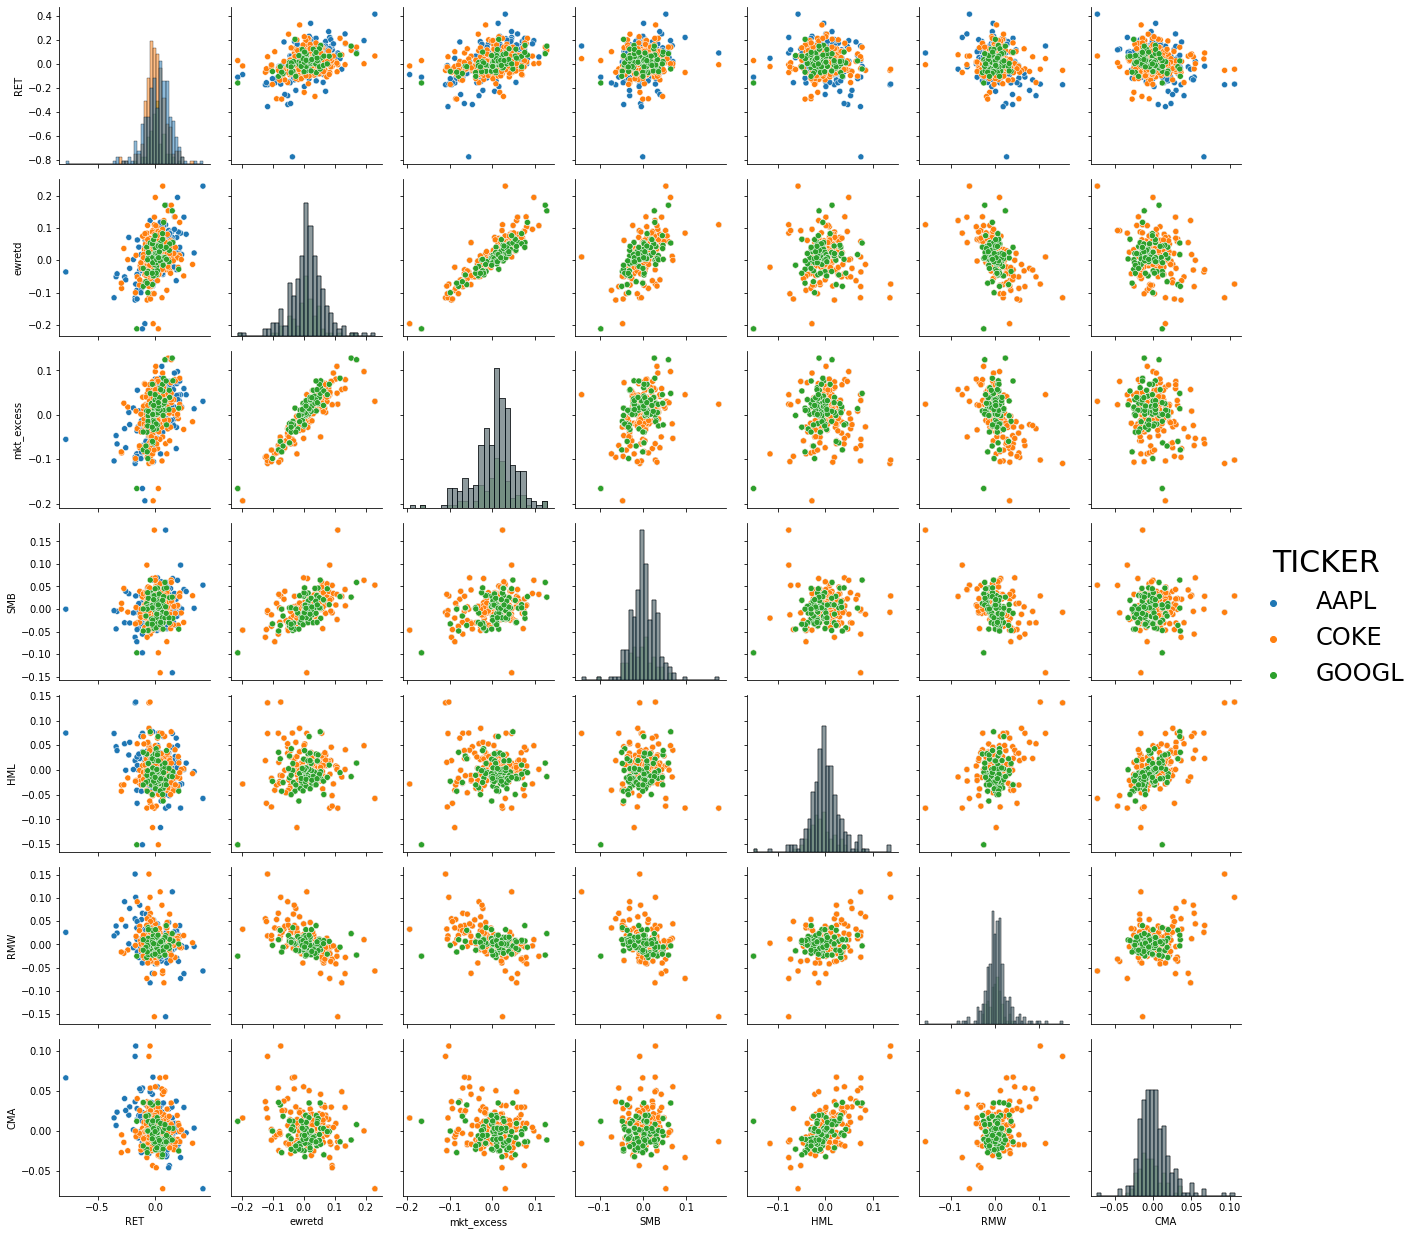

In [9]:
g = sns.PairGrid(data_filt, hue="TICKER")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend(fontsize=24)
plt.setp(g._legend.get_title(), fontsize=30)
plt.show()


In [10]:
data_AAPL = data_filt.query("TICKER == 'AAPL'")
data_AAPL = data_AAPL.drop(columns=['TICKER','ewretd'],axis=1)
data_AAPL


,Date,RET,mkt_excess,SMB,HML,RMW,CMA
0,2000-01-31,-0.026512,-0.049817,0.042313,-0.022284,-0.062559,0.046051
1,2000-02-29,0.088513,0.023900,0.175060,-0.077177,-0.156429,-0.013442
2,2000-03-31,0.146552,0.045368,-0.141438,0.074089,0.113542,-0.015726
3,2000-04-30,-0.111473,-0.069142,-0.055609,0.074341,0.067247,0.053853
4,2000-05-31,-0.339764,-0.046803,-0.044118,0.047078,0.039743,0.006877
...,...,...,...,...,...,...,...
247,2020-08-31,0.210880,0.076088,-0.009448,-0.029964,0.040520,-0.013719
248,2020-09-30,-0.113919,-0.038699,0.000152,-0.030188,-0.012516,-0.018802
249,2020-10-31,-0.067674,-0.022722,0.046907,0.039253,-0.005573,-0.005520
250,2020-11-30,0.092067,0.124006,0.058971,0.013968,-0.023112,0.007975


In [11]:
corr = data_AAPL.corr()
corr.style.background_gradient(cmap='coolwarm')

,RET,mkt_excess,SMB,HML,RMW,CMA
RET,1.000000,0.543746,0.192558,-0.257976,-0.293607,-0.429433
mkt_excess,0.543746,1.000000,0.319136,0.015444,-0.416434,-0.244754
SMB,0.192558,0.319136,1.000000,0.049938,-0.451920,0.007135
HML,-0.257976,0.015444,0.049938,1.000000,0.403998,0.592861
RMW,-0.293607,-0.416434,-0.451920,0.403998,1.000000,0.316132
CMA,-0.429433,-0.244754,0.007135,0.592861,0.316132,1.000000


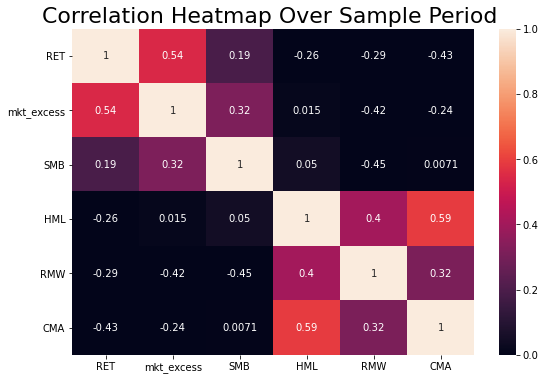

In [12]:
fig = plt.figure(figsize=(9, 6))
sns.heatmap(corr,annot=True,robust=True,vmin=0)
plt.title('Correlation Heatmap Over Sample Period ',fontsize=22)
plt.show()

In [13]:
data_decade = Returns_monthly.copy()
data_decade = data_decade.drop(columns=['sprtrn','RF','month','ewretd'],axis=1)

data_AAPL_2010 = data_decade[(data_decade['year'] < 2011) & (data_decade['TICKER'] == 'AAPL')]
data_AAPL_2020 = data_decade[(data_decade['year'] > 2010) & (data_decade['TICKER'] == 'AAPL')]
data_AAPL_2010 = data_AAPL_2010.drop(columns=['year'],axis=1)
data_AAPL_2020 = data_AAPL_2020.drop(columns=['year'],axis=1)


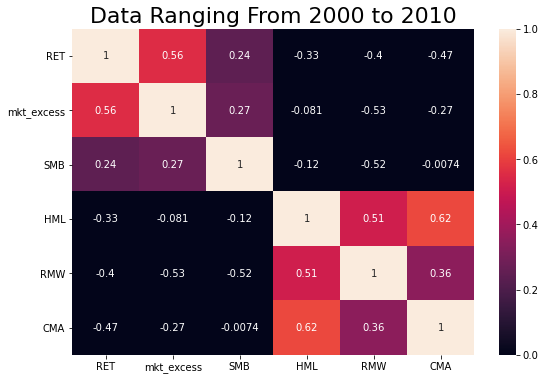

In [14]:
fig = plt.figure(figsize=(9, 6))
corr_2010 = data_AAPL_2010.corr()
heatmap_2010 = sns.heatmap(corr_2010,annot=True,robust=True,vmin=0)
plt.title('Data Ranging From 2000 to 2010',fontsize=22)
plt.show()

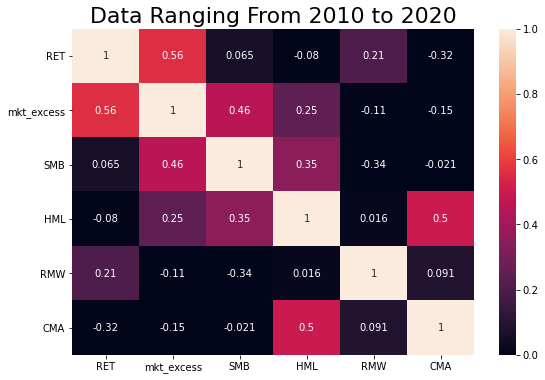

In [15]:
fig = plt.figure(figsize=(9, 6))

corr_2020 = data_AAPL_2020.corr()
heatmap_2020 = sns.heatmap(corr_2020,annot=True,robust=True,vmin=0)
plt.title('Data Ranging From 2010 to 2020',fontsize=22)
plt.show()